# Gram-schmidt and the KF

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
%config InlineBackend.figure_format = "retina"

## The best linear unbiased predictor for a signal plus noise model

$$
    {\bf A}_\text{opt} = \arg\min_{\bf A}\| f_t - {\bf A}\,y_{1:t} \|_2^2
$$

In [5]:
def ssm(key, signal_init, n_steps, qt, rt):
    def ssm_step(signal_prev, key):
        key_measurement, key_state = jax.random.split(key)
        ut = jax.random.normal(key_state) * qt
        et = jax.random.normal(key_measurement) * rt

        signal = signal_prev + ut
        measurement = signal + et

        return signal, (signal, measurement)

    keys = jax.random.split(key, n_steps)
    _, (signals, measurements) = jax.lax.scan(ssm_step, signal_init, keys)
    return signals, measurements

In [112]:
key = jax.random.PRNGKey(314)
key_sample, key_test = jax.random.split(key)

In [113]:
signal_init = 0.0
n_steps = 100
qt = 0.05
rt = 0.1
signals, measurements = ssm(key, signal_init, n_steps, qt, rt)

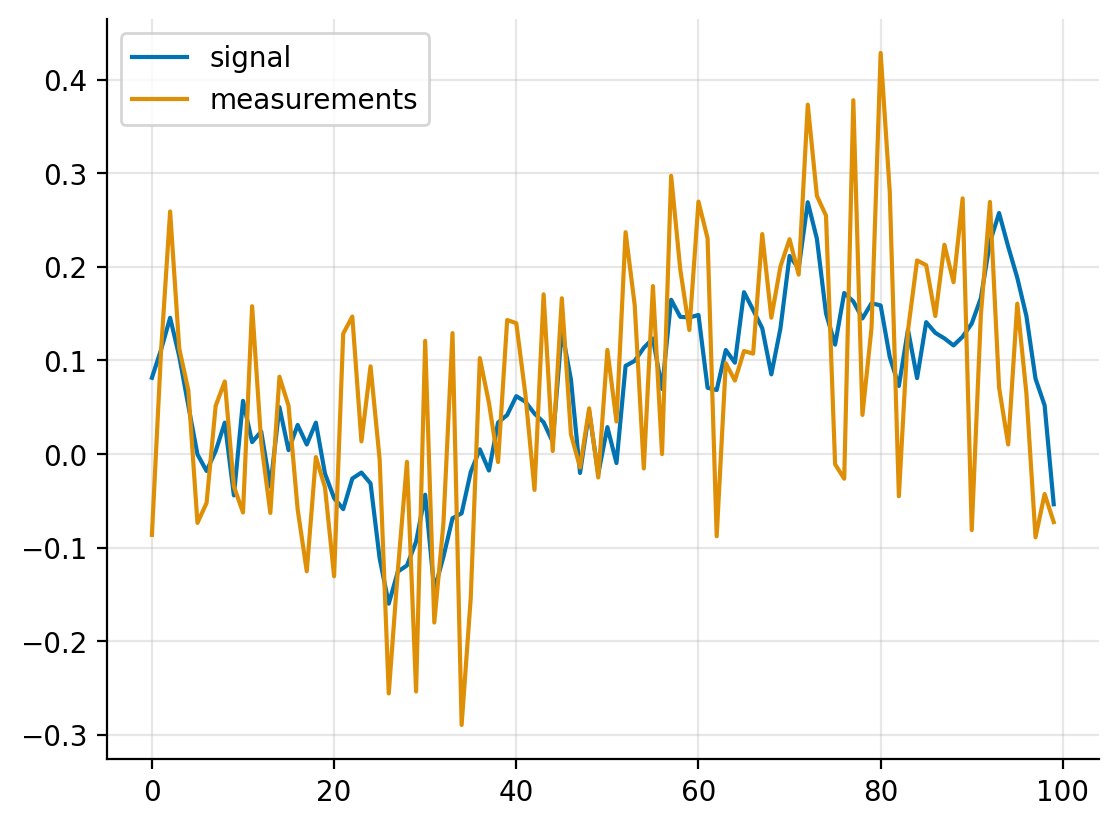

In [114]:
plt.plot(signals, label="signal")
plt.plot(measurements, label="measurements")
plt.legend()
plt.grid(alpha=0.3)

In [115]:
vssm = jax.vmap(ssm, in_axes=(0, None, None, None, None), out_axes=-1)

In [118]:
n_trials = 500
keys = jax.random.split(key_sample, n_trials)

In [119]:
n_steps = 100
signal_init = 0.0
rt = 0.1
qt = 0.05

signals, measurements = vssm(keys, signal_init, n_steps, qt, rt)

In [120]:
signals.shape

(100, 500)

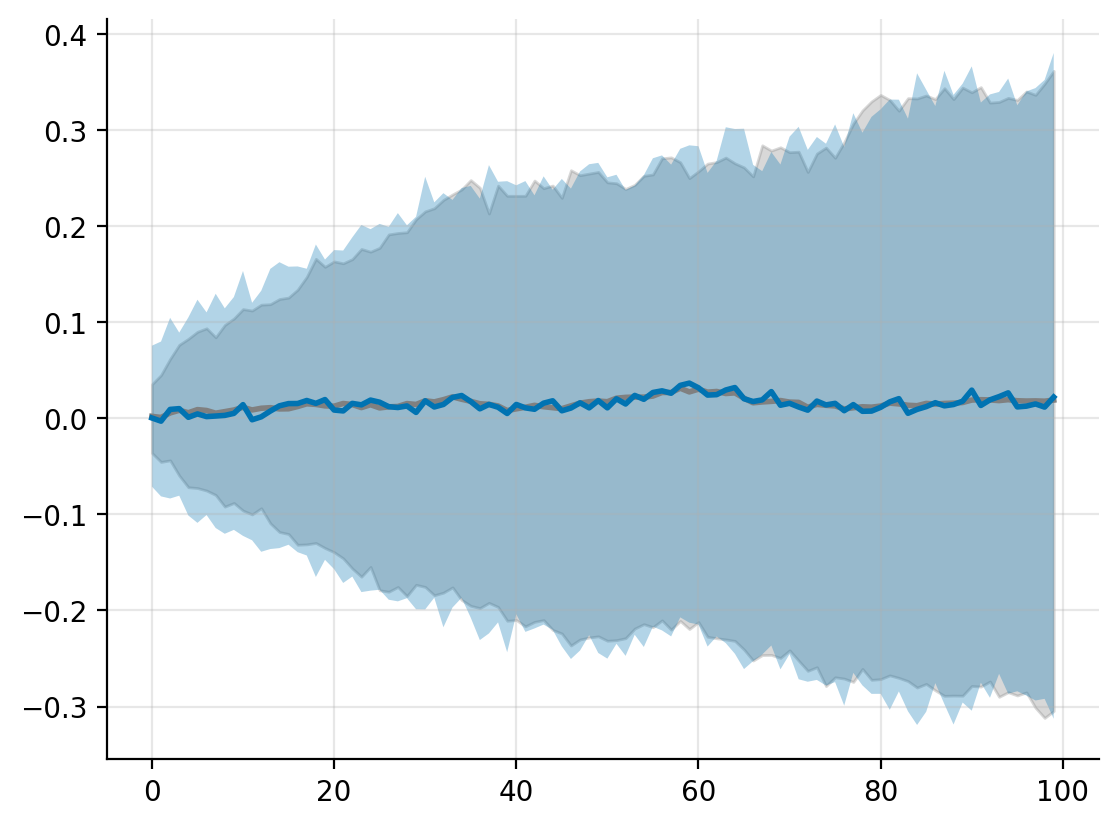

In [121]:
xrange = jnp.arange(n_steps)

smid = signals.mean(axis=1)
shigh = jnp.quantile(signals, 0.75, axis=1)
sslow = jnp.quantile(signals, 0.25, axis=1)

plt.fill_between(xrange, shigh, sslow, color="gray", alpha=0.3)
plt.plot(xrange, smid, c="gray", linewidth=2)

# plt.plot(signals.T)
plt.grid(alpha=0.3)

xrange = jnp.arange(n_steps)

smid = measurements.mean(axis=1)
shigh = jnp.quantile(measurements, 0.75, axis=1)
sslow = jnp.quantile(measurements, 0.25, axis=1)

plt.fill_between(xrange, shigh, sslow, alpha=0.3)
plt.plot(xrange, smid, linewidth=2)

# plt.plot(signals.T)
plt.grid(alpha=0.3)

In [122]:
measurements.shape

(100, 500)

In [123]:
signals.shape

(100, 500)

In [124]:
C = jnp.r_[signals[-1, :][None, :], measurements]
C = jnp.cov(C)
C.shape

(101, 101)

In [125]:
var_f = C[0, 0]
cov_fy = C[0, 1:] # Cov(ft, y[1:t])
var_y = C[1:, 1:] # var(yt)

In [126]:
A = jnp.einsum("i,ij->j", cov_fy, jnp.linalg.inv(var_y))
blup = A @ measurements[:, 0]
blup

Array(0.27003008, dtype=float32)

In [127]:
blup = jnp.einsum("i,ij,j->", cov_fy, jnp.linalg.inv(var_y), measurements[:, 0])
blup

Array(0.27003008, dtype=float32)

In [128]:
s = jnp.sqrt(var_f - A @ var_y @ A.T)

ymin, ymax = float(blup - 2 * s), float(blup + 2 * s)

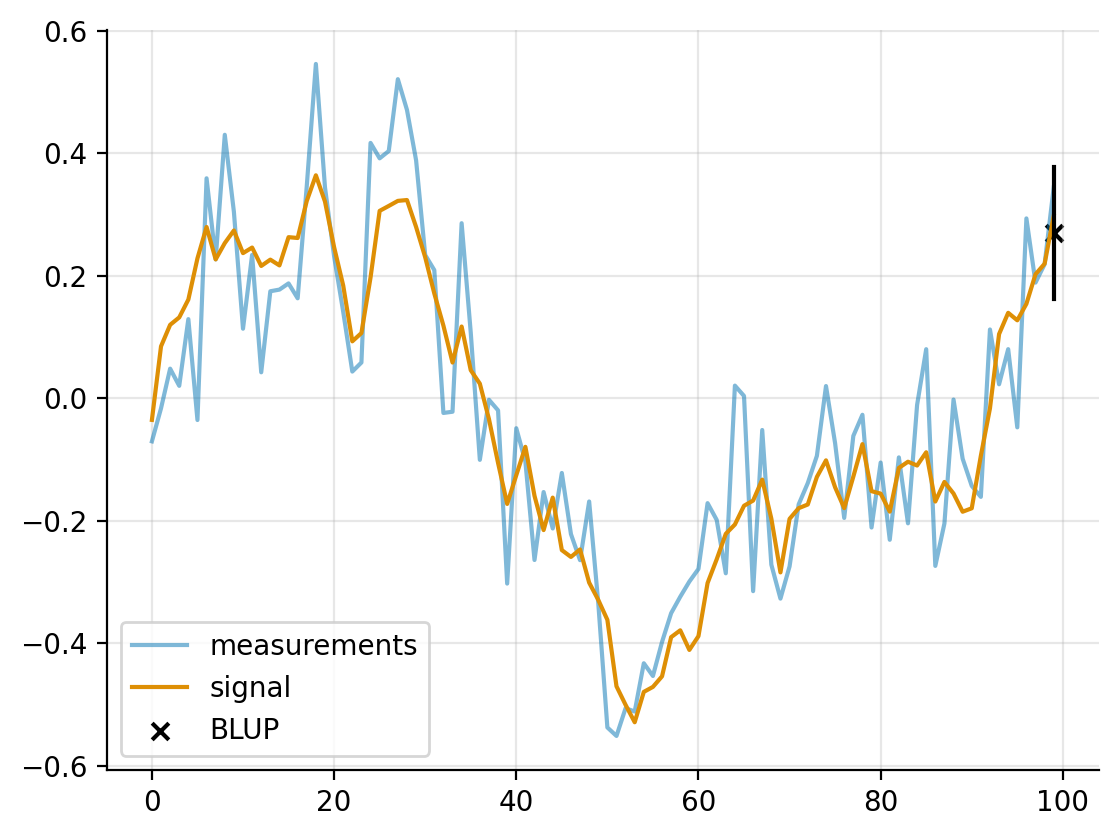

In [129]:
plt.plot(xrange, measurements[:, 0], label="measurements", alpha=0.5)
plt.plot(xrange, signals[:, 0], label="signal")

plt.plot([xrange[-1], xrange[-1]], [ymin, ymax], c="black")
plt.scatter(xrange[-1], blup, label="BLUP", c="black", marker="x")
plt.legend()
plt.grid(alpha=0.3)

## Numerical smoothing

Compute the BLUP for all datapoints up to time $t$

In [130]:
C = jnp.r_[signals[-1:, :], measurements]
C = jnp.cov(C)
C.shape

(101, 101)

In [131]:
cov_fy = C[0, 1:] # Cov(ft, y[1:t])
var_y = C[1:, 1:] # var(yt)

In [132]:
A = jnp.einsum("i,ij->j", cov_fy, jnp.linalg.inv(var_y))
blup = A @ measurements[:, 0]
blup

Array(0.27003008, dtype=float32)

## Smoothing — $f_{k|t}$
For $k=1,\ldots,t$.

In [143]:
C = jnp.r_[signals[:, :], measurements]
C = jnp.cov(C)
C.shape

(200, 200)

In [144]:
cov_fy = C[:n_steps, n_steps:] # Cov(ft, y[1:t])
var_y = C[n_steps:, n_steps:] # var(yt)

In [145]:
jnp.trace(var_y)

Array(13.138532, dtype=float32)

In [146]:
blup_ts = jnp.einsum("ti,ij,j->t", cov_fy, jnp.linalg.inv(var_y), measurements[:, 0])

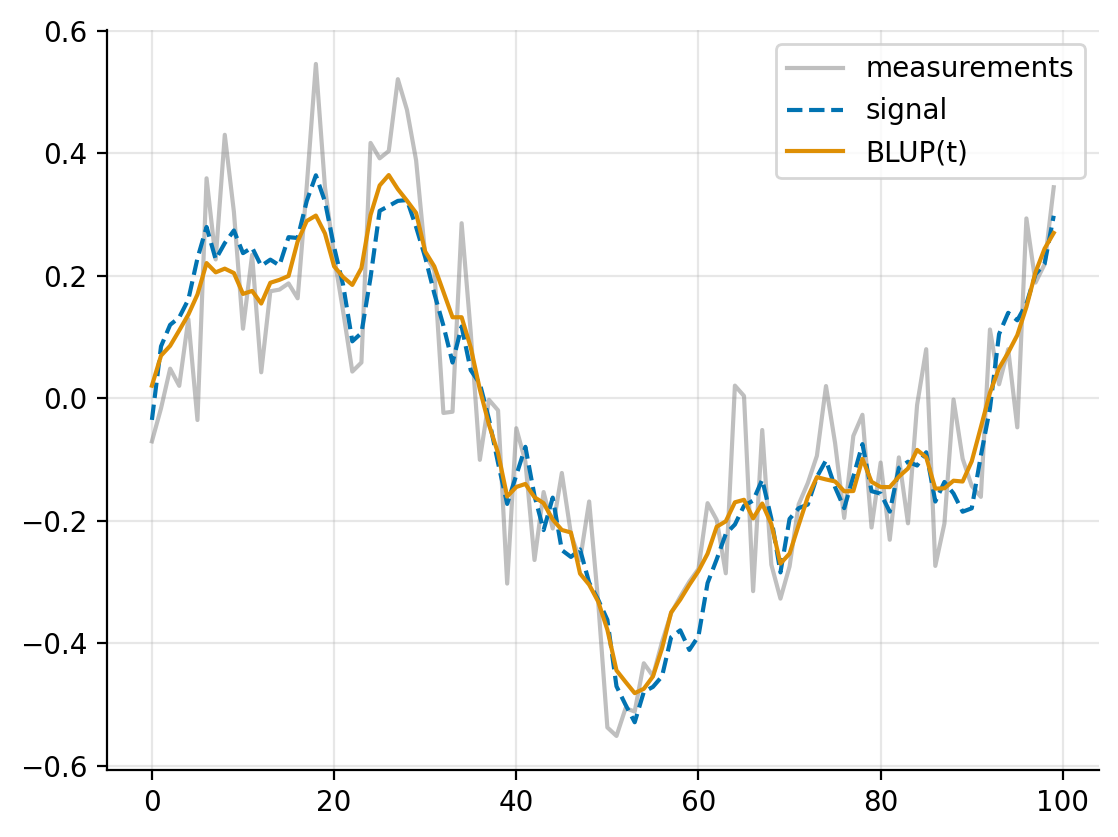

In [147]:
plt.plot(xrange, measurements[:, 0], label="measurements", alpha=0.5, c="gray")
plt.plot(xrange, signals[:, 0], label="signal", linestyle="--")
plt.plot(blup_ts, label="BLUP(t)")
plt.legend()
plt.grid(alpha=0.3)

The BLUP estimate over multiple samples can be evaluated in an out-of-sample test-set.
That is
$$
    f_{t|j} = {\rm Cov}(f_t, y_{1:j})\,{\rm Var}(y_{1:j})^{-1}\,y_{1:j}
$$
can be better thought of as
$$
    f_{t|j} = {\rm Cov}(F_t, Y_{1:j})\,{\rm Var}(Y_{1:j})^{-1}\,y_{1:j}
$$
with $F_t$ and $Y_{1:j}$ a sequence of random variables and $y_{1:j}$ the measurements.

In [151]:
n_trials_test = 20
keys_test = jax.random.split(key_test, n_trials_test)

In [152]:
signals_test, measurements_test = vssm(keys_test, signal_init, n_steps, qt, rt)

In [167]:
blup_test = jnp.einsum("ti,ij,js->ts", cov_fy, jnp.linalg.inv(var_y), measurements_test)

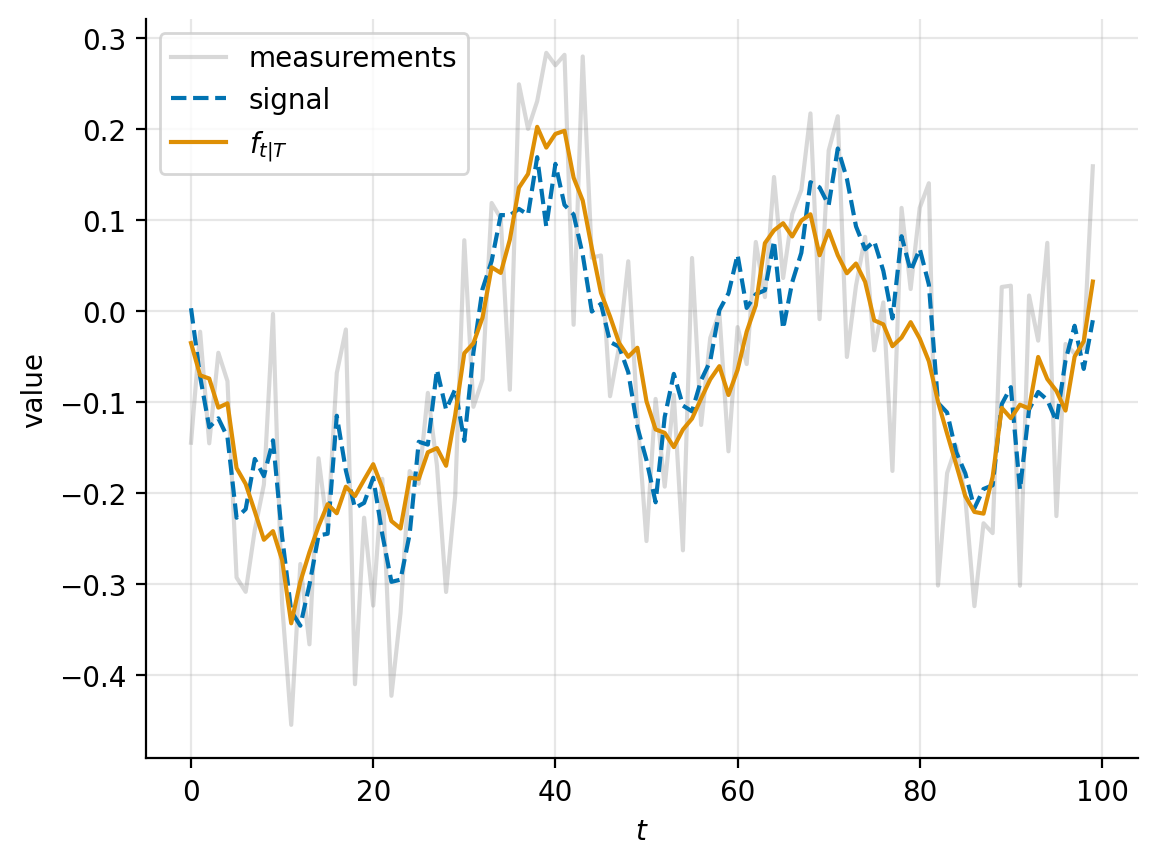

In [172]:
s = 3
plt.plot(xrange, measurements_test[:, s], label="measurements", alpha=0.3, c="gray")
plt.plot(xrange, signals_test[:, s], label="signal", linestyle="--")
plt.plot(blup_test[:, s], label="$f_{t|T}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("value")
plt.grid(alpha=0.3)

## Filtering — $f_{t|t}$
For $t=1,\ldots,T$.

$$
    f_{t|t} = {\rm Cov}(F_t, Y_{1:t})\,{\rm Var}(Y_{1:t})^{-1}\,y_{1:t}
$$

## One-step-ahead forecast — $f_{t|t-1}$
For $t=1,\ldots,T$.

$$
    f_{t|t} = {\rm Cov}(F_t, Y_{1:t})\,{\rm Var}(Y_{1:t})^{-1}\,y_{1:t}
$$

## Fixed-lag smoothing — $f_{t+k|t}$
For $t=1,\ldots,T$.

$$
    f_{t|t} = {\rm Cov}(F_{t+k}, Y_{1:t})\,{\rm Var}(Y_{1:t})^{-1}\,y_{1:t}
$$